## Vehicle Detection Project

The goals / steps of this project are the following:

* Decide what feature to use (color based, gradient based, etc...) to extract HOG feature
* Choose and train a classifier (linear svm is the best bet!)
    * Features should be scaled to zero mean and unit variance before training the classifier
* Implement a sliding window technique to find vehicles in images
* Create heatmap to reduce duplicate or false-positive detections

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

### Define functions to extract features

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range to (0, 1) if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, data_flip=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        # flip data
        if data_flip:
            image = cv2.flip(image, 1)
        # apply color conversion if other than 'BGR'
        if color_space != 'BGR':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Load data

In [21]:
# Read in cars and notcars
car_images = glob.glob('./vehicles/*/*.png')
notcar_images = glob.glob('./non-vehicles/*/*.png')
cars = []
notcars = []
for image in car_images:
    cars.append(image)
for image in notcar_images:
    notcars.append(image)

print('num of car images: ', len(cars))
print('num of notcar images: ', len(notcars))

num of car images:  8792
num of notcar images:  8968


### Parameters to tune

In [22]:
# Tweak these parameters and see how the results change
color_space = 'LUV' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

### HOG visualization

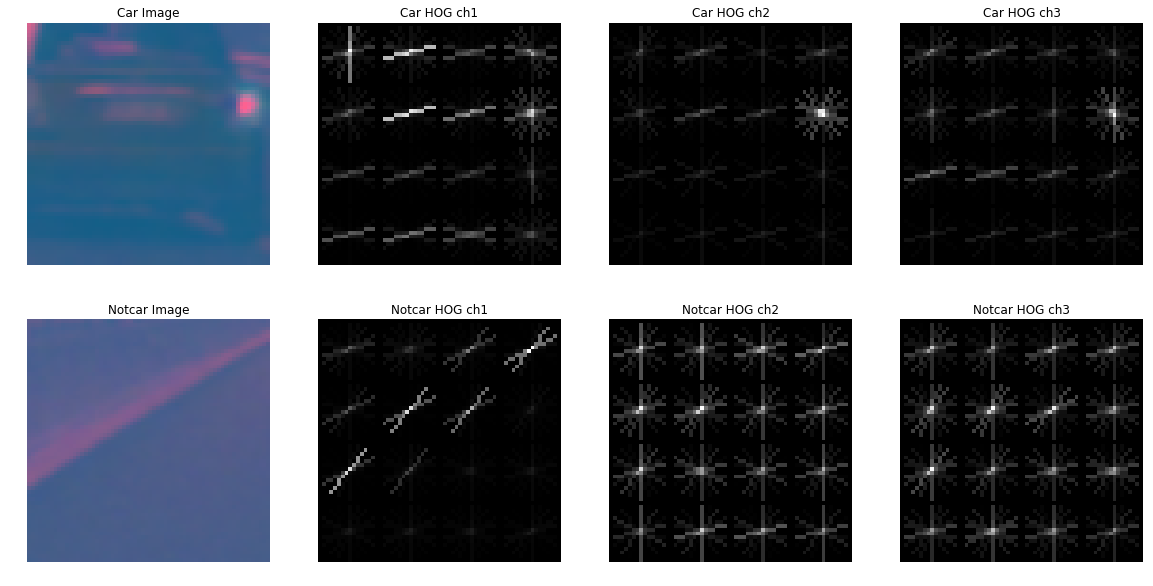

In [25]:
car_image = cv2.imread(cars[1])
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2LUV)
_, car_hog_c1 = get_hog_features(car_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, car_hog_c2 = get_hog_features(car_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, car_hog_c3 = get_hog_features(car_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
notcar_image = cv2.imread(notcars[1])
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2LUV)
_, notcar_hog_c1 = get_hog_features(notcar_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, notcar_hog_c2 = get_hog_features(notcar_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, notcar_hog_c3 = get_hog_features(notcar_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.ravel()

axs[0].axis('off')
axs[0].imshow(car_image)
axs[0].set_title('Car Image')
axs[1].axis('off')
axs[1].imshow(car_hog_c1, cmap='gray')
axs[1].set_title('Car HOG ch1')
axs[2].axis('off')
axs[2].imshow(car_hog_c2, cmap='gray')
axs[2].set_title('Car HOG ch2')
axs[3].axis('off')
axs[3].imshow(car_hog_c3, cmap='gray')
axs[3].set_title('Car HOG ch3')

axs[4].axis('off')
axs[4].imshow(notcar_image)
axs[4].set_title('Notcar Image')
axs[5].axis('off')
axs[5].imshow(notcar_hog_c1, cmap='gray')
axs[5].set_title('Notcar HOG ch1')
axs[6].axis('off')
axs[6].imshow(notcar_hog_c2, cmap='gray')
axs[6].set_title('Notcar HOG ch2')
axs[7].axis('off')
axs[7].imshow(notcar_hog_c3, cmap='gray')
axs[7].set_title('Notcar HOG ch3')

In [26]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, data_flip=False)
'''
car_features_flip = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, data_flip=True)
'''
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, data_flip=False)
'''
notcar_features_flip = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, data_flip=True)
'''

#X = np.vstack((car_features, car_features_flip, notcar_features, notcar_features_flip))
X = np.vstack((car_features, notcar_features))
X_scaler = None
if [spatial_feat, hist_feat, hog_feat].count(True) > 1:
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    X = X_scaler.transform(X)

# Define the labels vector
#y = np.hstack((np.ones(len(car_features)), np.ones(len(car_features)), np.zeros(len(notcar_features)), np.zeros(len(notcar_features))))
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

### Train a classifier

In [27]:
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 972
0.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9873


### Define functions to process a region of interest of an image at once (sliding window and heatmap)

In [28]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # apply color conversion if other than 'BGR'
    if color_space != 'BGR':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Define blocks and steps as above
    imshape = ctrans_tosearch.shape
    nxblocks = (imshape[1] // pix_per_cell) + 1
    nyblocks = (imshape[0] // pix_per_cell) + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    if hog_feat == True:
        if hog_channel == 'ALL':
            # Compute individual channel HOG features for the entire image
            hog1 = get_hog_features(ctrans_tosearch[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ctrans_tosearch[:,:,1], orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ctrans_tosearch[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=False)
        else:
            hog = get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Initialize a list to append window positions to
    window_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            features = []
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
          
            if spatial_feat == True:
                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                spatial_features = bin_spatial(subimg, size=spatial_size)
                features.append(spatial_features)
            if hist_feat == True:
                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                hist_features = color_hist(subimg, nbins=hist_bins)
                features.append(hist_features)
            
            if hog_feat == True:
                if hog_channel == 'ALL':
                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_features = np.ravel((hog_feat1, hog_feat2, hog_feat3))
                else:
                    hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                features.append(hog_features)

            # Scale features and make a prediction
            if X_scaler is not None:
                test_features = X_scaler.transform(np.concatenate(features).reshape(1, -1))
            else:
                test_features = np.concatenate(features).reshape(1, -1)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                
                # Append window position to list
                window_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
    return draw_img, window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Experimentation and visualization

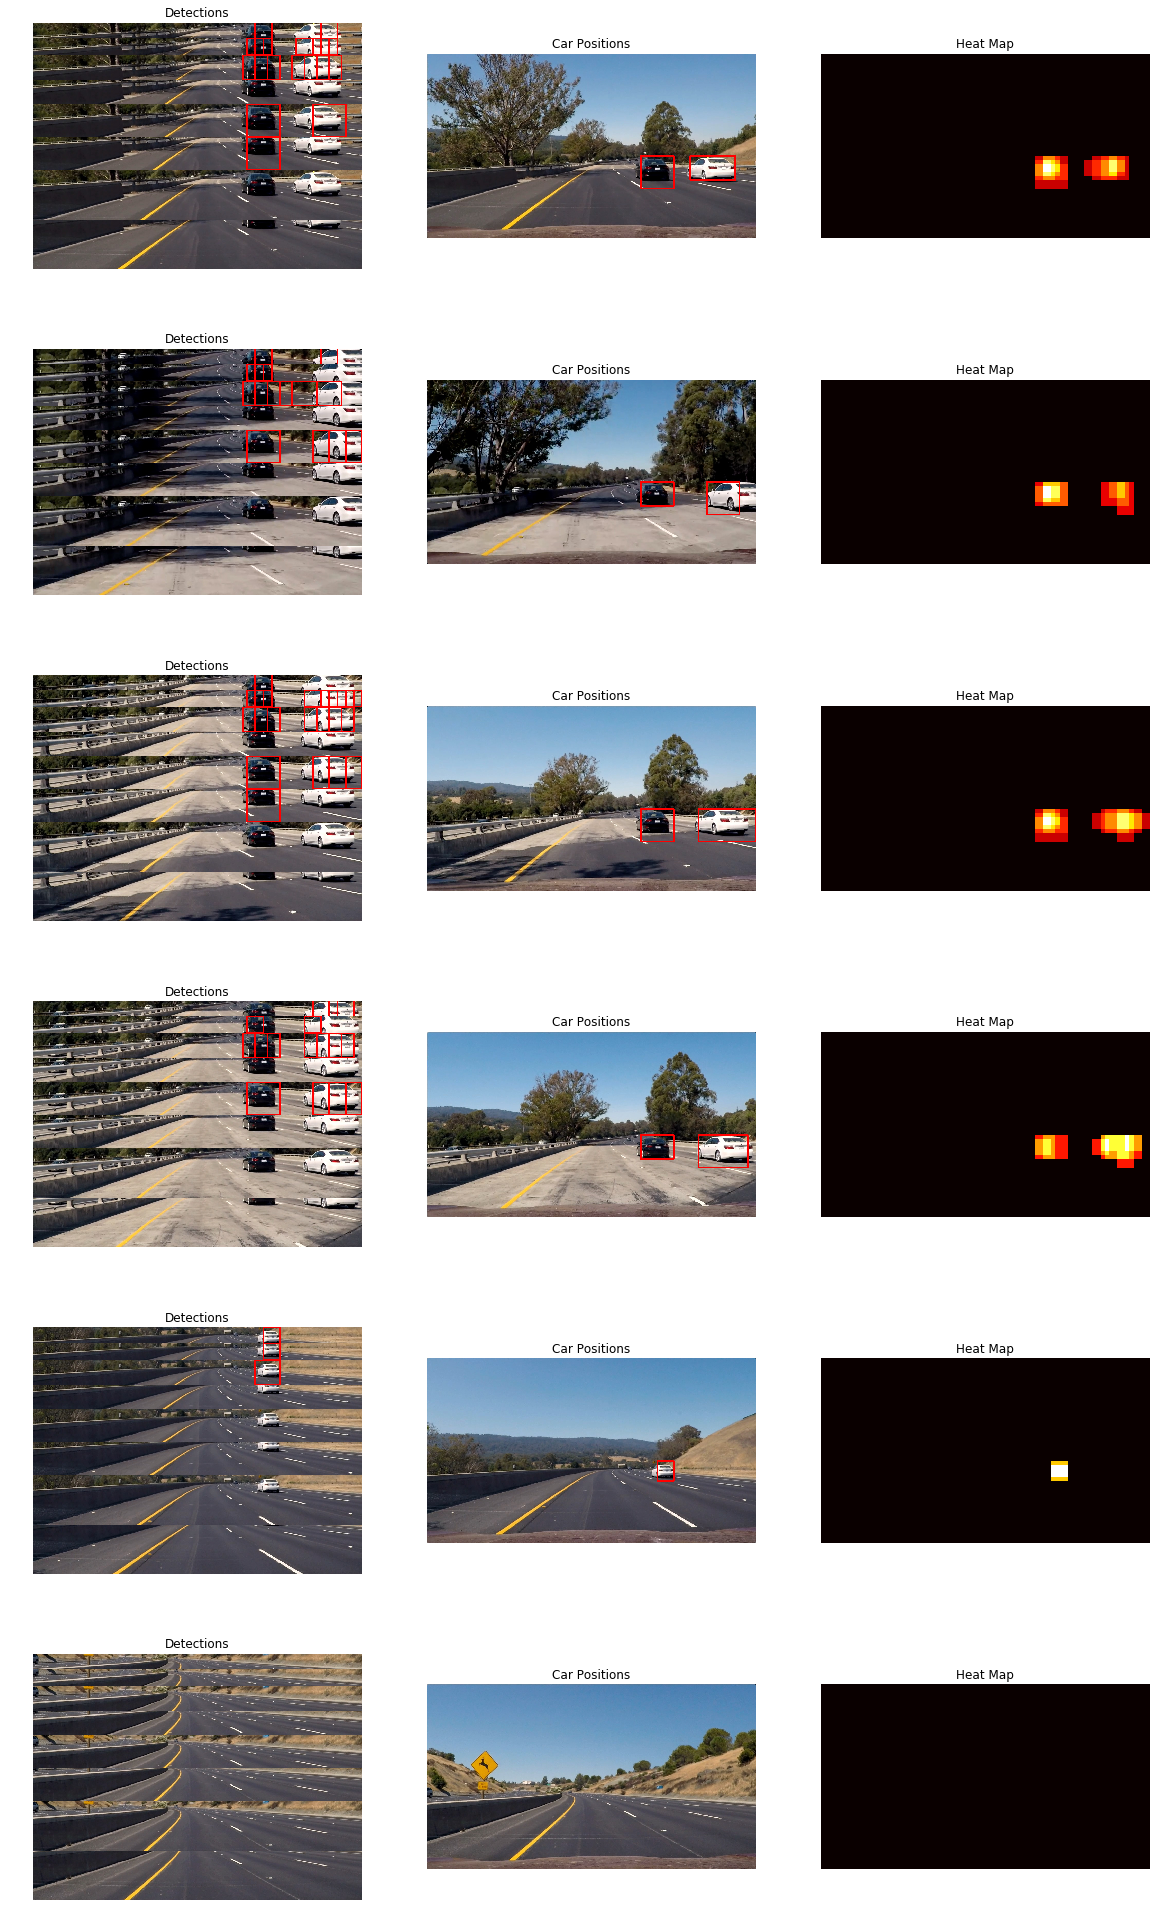

In [29]:
images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(6, 3, figsize=(20, 35))
axs = axs.ravel()

for i, file in enumerate(images):
    image = cv2.imread(file)

    scale = 1
    out_img1, box_list1 = find_cars(image, 400, 464, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 1
    out_img2, box_list2 = find_cars(image, 416, 480, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 1.5
    out_img3, box_list3 = find_cars(image, 400, 496, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 1.5
    out_img4, box_list4 = find_cars(image, 432, 528, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 2.0
    out_img5, box_list5 = find_cars(image, 400, 528, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 2.0
    out_img6, box_list6 = find_cars(image, 432, 560, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 3.0
    out_img7, box_list7 = find_cars(image, 400, 592, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 3.0
    out_img8, box_list8 = find_cars(image, 464, 656, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    
    out_img = np.concatenate((out_img1[400:464, :], out_img2[416:480, :],
                              out_img3[400:496, :], out_img4[432:528, :],
                              out_img5[400:528, :], out_img6[432:560, :],
                              out_img7[400:592, :], out_img8[464:656, :]), axis=0)
    box_list = box_list1 + box_list2 + box_list3 + box_list4 + box_list5 + box_list6 + box_list7 + box_list8
    
    heat = np.zeros_like(image[:,:,0])

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heat,1)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
            
    axs[i*3].axis('off')
    axs[i*3].imshow(out_img[:,:,::-1])
    axs[i*3].set_title('Detections')
    axs[i*3+1].axis('off')
    axs[i*3+1].imshow(draw_img[:,:,::-1])
    axs[i*3+1].set_title('Car Positions')
    axs[i*3+2].axis('off')
    axs[i*3+2].imshow(heatmap, cmap='hot')
    axs[i*3+2].set_title('Heat Map')

### Define a function to process video frame by frame

In [30]:
def process_image(image):
    scale = 1
    out_img1, box_list1 = find_cars(image, 400, 464, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 1
    out_img2, box_list2 = find_cars(image, 416, 480, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 1.5
    out_img3, box_list3 = find_cars(image, 400, 496, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 1.5
    out_img4, box_list4 = find_cars(image, 432, 528, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 2.0
    out_img5, box_list5 = find_cars(image, 400, 528, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 2.0
    out_img6, box_list6 = find_cars(image, 432, 560, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 3.0
    out_img7, box_list7 = find_cars(image, 400, 592, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 3.0
    out_img8, box_list8 = find_cars(image, 464, 656, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    
    out_img = np.concatenate((out_img1[400:464, :], out_img2[416:480, :],
                              out_img3[400:496, :], out_img4[432:528, :],
                              out_img5[400:528, :], out_img6[432:560, :],
                              out_img7[400:592, :], out_img8[464:656, :]), axis=0)
    box_list = box_list1 + box_list2 + box_list3 + box_list4 + box_list5 + box_list6 + box_list7 + box_list8
    
    heat = np.zeros_like(image[:,:,0])

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heat,1)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
            
    return draw_img

In [31]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Process video

In [32]:
output_video = 'test_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_video.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:09<00:00,  3.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 10.6 s, sys: 496 ms, total: 11.1 s
Wall time: 10.6 s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

### Define a class to store time-series detections (to reduce false positive)

In [34]:
# Define a class to store data from video
class Bbox():
    def __init__(self):
        self.history = []

In [35]:
def process_image(image):
    scale = 1
    out_img1, box_list1 = find_cars(image, 400, 464, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 1
    out_img2, box_list2 = find_cars(image, 416, 480, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 1.5
    out_img3, box_list3 = find_cars(image, 400, 496, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 1.5
    out_img4, box_list4 = find_cars(image, 432, 528, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 2.0
    out_img5, box_list5 = find_cars(image, 400, 528, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 2.0
    out_img6, box_list6 = find_cars(image, 432, 560, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 3.0
    out_img7, box_list7 = find_cars(image, 400, 592, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    scale = 3.0
    out_img8, box_list8 = find_cars(image, 464, 656, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, spatial_feat, hist_feat, hog_feat, hog_channel, X_scaler)
    
    out_img = np.concatenate((out_img1[400:464, :], out_img2[416:480, :],
                              out_img3[400:496, :], out_img4[432:528, :],
                              out_img5[400:528, :], out_img6[432:560, :],
                              out_img7[400:592, :], out_img8[464:656, :]), axis=0)
    box_list = box_list1 + box_list2 + box_list3 + box_list4 + box_list5 + box_list6 + box_list7 + box_list8
    
    bbox.history.append(box_list)
    if len(bbox.history) > 30:
        bbox.history = bbox.history[len(bbox.history)-30:]
    
    heat = np.zeros_like(image[:,:,0])

    for box_list in bbox.history:
        heat = add_heat(heat, box_list)
    
    heatmap = apply_threshold(heat, len(bbox.history))

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
            
    return draw_img

In [36]:
bbox = Bbox()

output_video = 'test_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_video.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:10<00:00,  3.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 11 s, sys: 575 ms, total: 11.6 s
Wall time: 11.1 s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [38]:
bbox = Bbox()

output_video = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(5,15)
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:38<00:00,  3.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 59s, sys: 18.2 s, total: 6min 17s
Wall time: 5min 38s


In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))